### Δεδομένα

Data Link: https://www.cryptodatadownload.com/data/binance/ 

Τα δεδομένα που χρησιμοποιούμε είναι από την πλατφόρμα της binance.

### Λίγες πληρφορίες για αυτά:

Περιέχουν τις πληροφορίες του bitcoin ανά λεπτό.


Επίσης η πληροφορία που μας ενδιαφέρει είναι το close του BTC. Το close είναι η τιμή που διαμορφόθηκε εκείνη τη στιγμή στο bitcoin. Το volume είναι η ποσότητα που αγοράστηκε/πουλήθηκε εκείνη τι στιγμή. 

'Αρα στην ουσία το close είναι η τιμή ενός BTC που συναλλάχθηκε εκέίνη τη στιγμή και το volume είναι η ποσότητα που συναλλάχθηκε.

Το open είναι η τιμή που άνοιξε στο bitcoin, το low είναι η χαμηλότερη τιμή πώλησης του ανοίγματος και το high η ηψυλότερη τιμή

# Εισάγουμε τις βιβλίοθηκες

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import mplfinance as mpf
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score, r2_score
from sklearn.preprocessing import MinMaxScaler
import random
import time
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, LSTM, BatchNormalization
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard
import tensorflow as tf
%matplotlib inline

In [2]:
btc_input_df  = pd.read_csv("btc_Oct_2015_to_Oct_2021.csv", parse_dates=["time"], nrows=1440)
btc_input_df.head()

,time,low,high,open,close,volume
0,2021-10-30 03:00:00,61868.81,61920.00,61888.18,61919.98,2.946079
1,2021-10-30 02:59:00,61882.74,61912.67,61903.16,61882.74,2.942357
2,2021-10-30 02:58:00,61854.82,61907.96,61854.82,61903.15,3.047848
3,2021-10-30 02:57:00,61848.04,61883.02,61883.01,61851.39,3.381070
4,2021-10-30 02:56:00,61879.33,61925.42,61907.47,61882.28,5.663128


In [3]:
btc_input_df = btc_input_df.set_index('time')
btc_input_df.head()

,low,high,open,close,volume
time,,,,,
2021-10-30 03:00:00,61868.81,61920.00,61888.18,61919.98,2.946079
2021-10-30 02:59:00,61882.74,61912.67,61903.16,61882.74,2.942357
2021-10-30 02:58:00,61854.82,61907.96,61854.82,61903.15,3.047848
2021-10-30 02:57:00,61848.04,61883.02,61883.01,61851.39,3.381070
2021-10-30 02:56:00,61879.33,61925.42,61907.47,61882.28,5.663128


In [4]:
btc_input_df = btc_input_df.sort_index()
btc_input_df.head()

,low,high,open,close,volume
time,,,,,
2021-10-29 03:01:00,61649.50,61681.09,61649.50,61665.24,2.201539
2021-10-29 03:02:00,61603.45,61665.50,61665.24,61606.40,1.898041
2021-10-29 03:03:00,61593.32,61611.45,61605.16,61596.48,2.279936
2021-10-29 03:04:00,61546.11,61604.47,61596.47,61604.47,6.702590
2021-10-29 03:05:00,61601.65,61699.11,61601.69,61693.13,6.331365


In [5]:
print(btc_input_df.shape)
print("------------------------")
print(btc_input_df.info())

(1440, 5)
------------------------
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1440 entries, 2021-10-29 03:01:00 to 2021-10-30 03:00:00
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   low     1440 non-null   float64
 1   high    1440 non-null   float64
 2   open    1440 non-null   float64
 3   close   1440 non-null   float64
 4   volume  1440 non-null   float64
dtypes: float64(5)
memory usage: 67.5 KB
None


In [6]:
btc_input_df.head()

,low,high,open,close,volume
time,,,,,
2021-10-29 03:01:00,61649.50,61681.09,61649.50,61665.24,2.201539
2021-10-29 03:02:00,61603.45,61665.50,61665.24,61606.40,1.898041
2021-10-29 03:03:00,61593.32,61611.45,61605.16,61596.48,2.279936
2021-10-29 03:04:00,61546.11,61604.47,61596.47,61604.47,6.702590
2021-10-29 03:05:00,61601.65,61699.11,61601.69,61693.13,6.331365


In [7]:
btc_input_df.tail()

,low,high,open,close,volume
time,,,,,
2021-10-30 02:56:00,61879.33,61925.42,61907.47,61882.28,5.663128
2021-10-30 02:57:00,61848.04,61883.02,61883.01,61851.39,3.381070
2021-10-30 02:58:00,61854.82,61907.96,61854.82,61903.15,3.047848
2021-10-30 02:59:00,61882.74,61912.67,61903.16,61882.74,2.942357
2021-10-30 03:00:00,61868.81,61920.00,61888.18,61919.98,2.946079


<AxesSubplot:title={'center':'Bitcoin Price'}, xlabel='time'>

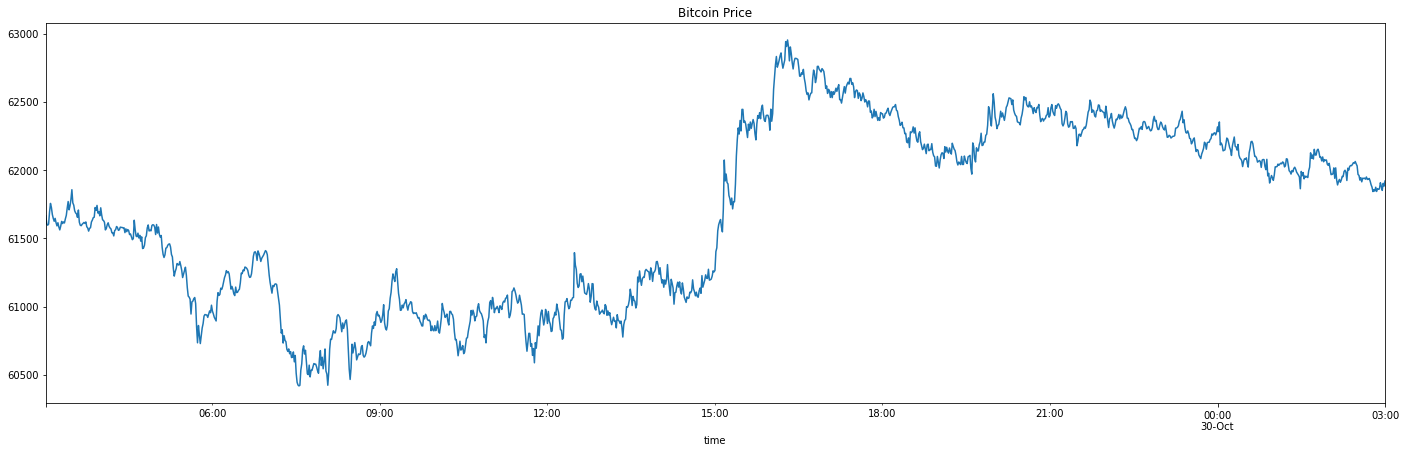

In [8]:
btc_input_df.close.plot(figsize=(24,7), title="Bitcoin Price")

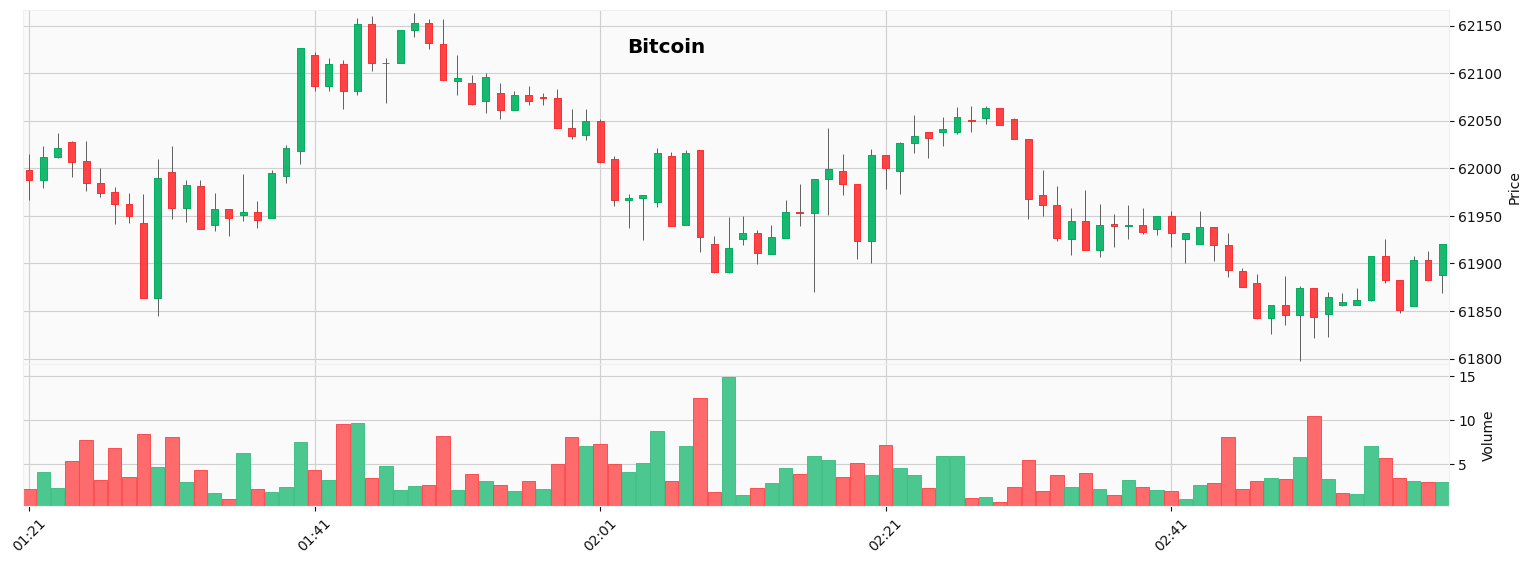

In [9]:
mpf.plot(btc_input_df[-100:],
         title="Bitcoin",
         type="candle", 
         volume=True,
         tight_layout=True,
         figratio=(20,7),
         style='yahoo',)

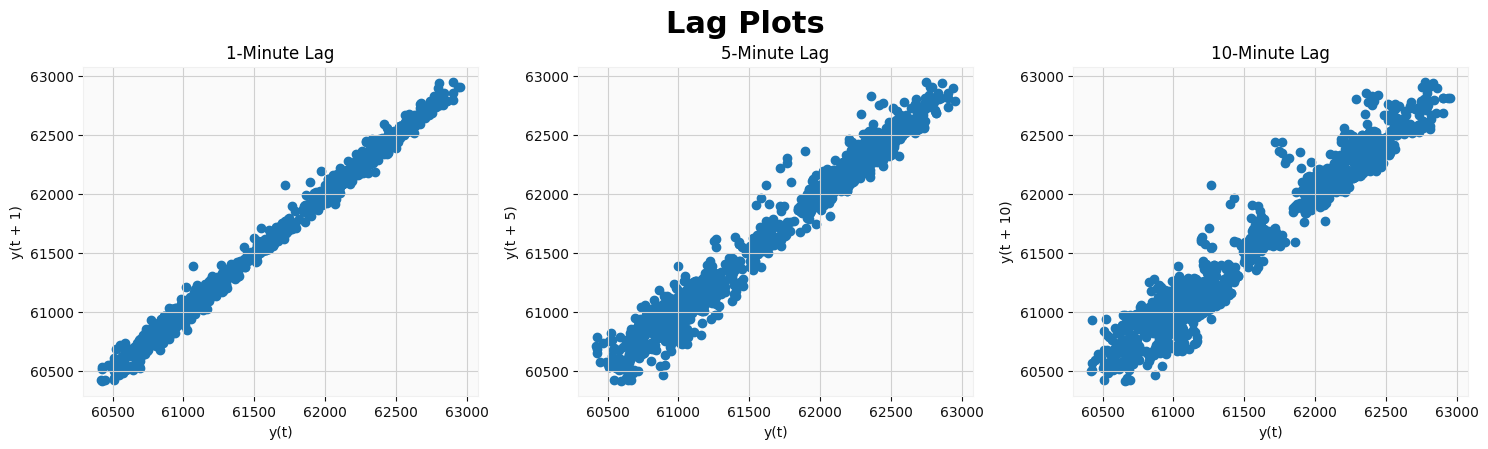

In [10]:
# κάνουμε plot το corelation 
plt.figure(figsize=(15,12))
plt.suptitle('Lag Plots', fontsize=22)

plt.subplot(3,3,1)
pd.plotting.lag_plot(btc_input_df['close'], lag=1) #minute lag
plt.title('1-Minute Lag')

plt.subplot(3,3,2)
pd.plotting.lag_plot(btc_input_df['close'], lag=5) 
plt.title('5-Minute Lag')

plt.subplot(3,3,3)
pd.plotting.lag_plot(btc_input_df['close'], lag=10) 
plt.title('10-Minute Lag')

plt.tight_layout()

In [11]:
btc_closing_price = btc_input_df['close'].copy()
btc_closing_price.head()

time
2021-10-29 03:01:00    61665.24
2021-10-29 03:02:00    61606.40
2021-10-29 03:03:00    61596.48
2021-10-29 03:04:00    61604.47
2021-10-29 03:05:00    61693.13
Name: close, dtype: float64

In [12]:
df_train= btc_closing_price[:-200].copy()
df_test= btc_closing_price[-200:].copy()

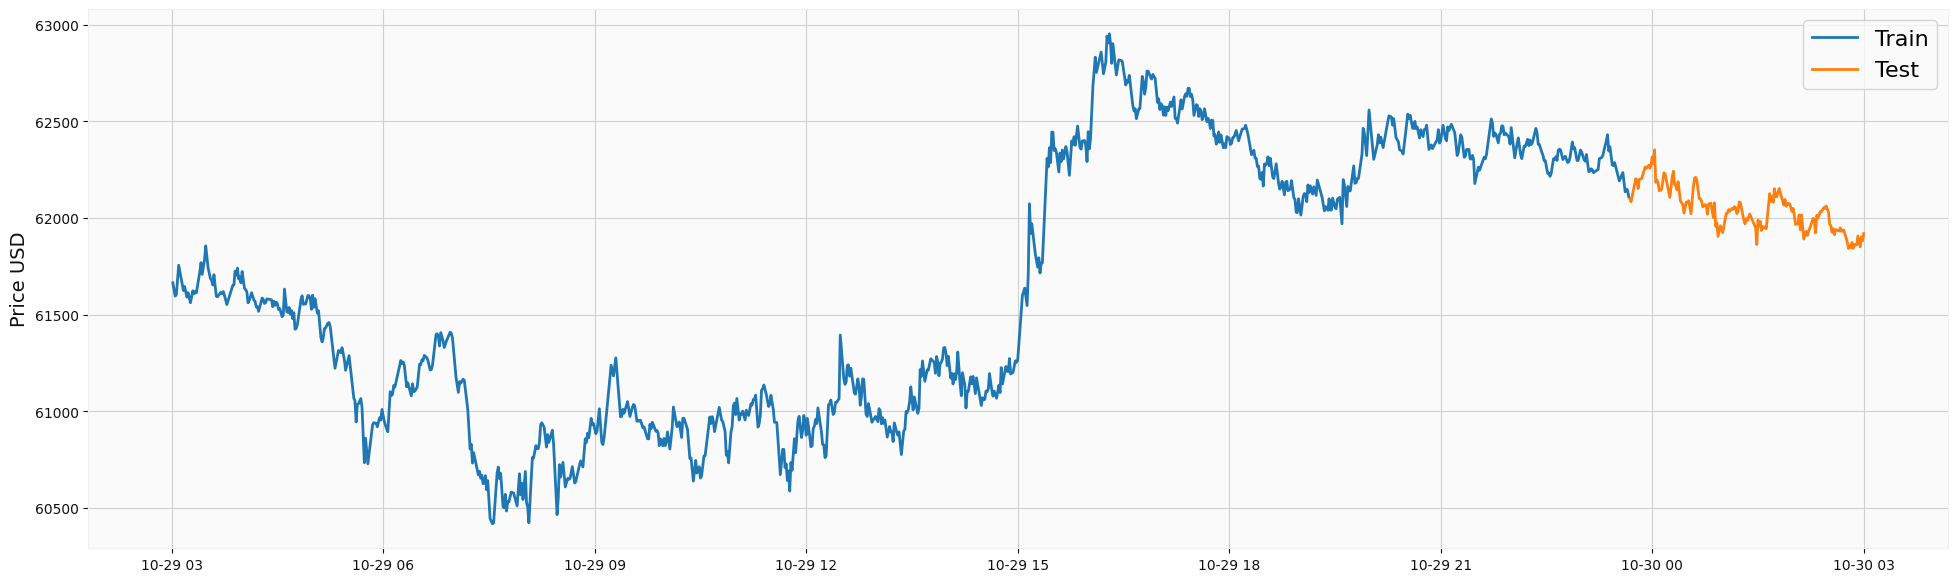

In [13]:
fig, ax = plt.subplots(1, figsize=(24, 7))
ax.plot(df_train, label='Train', linewidth=2)
ax.plot(df_test, label='Test', linewidth=2)
ax.set_ylabel('Price USD', fontsize=14)
ax.set_title('', fontsize=16)
ax.legend(loc='best', fontsize=16)

In [14]:
df_train= df_train.values.reshape(df_train.shape[0],1)
df_test= df_test.values.reshape(df_test.shape[0],1)

In [15]:
df_train.shape

(1240, 1)

In [16]:
"""
Ο λόγος που χωρίζουμε πρώτα τα δεδομένα μας και μετά τα κανονικοποιούμε
είναι διότι αν κάναμε το αντίθετο, όταν θα γινόταν το scaling, θα χρησιμοποιούνταν
(ως σημείο αναφοράς) τα δεδομένα που έχουμε ως training και αυτό θα επηρέαζε τα δεδομένα εκαπίδευσης.
Στην ουσία θα είχαμ "διαρροή" των αποτελεσμάτων του training set
"""
scaler_train = MinMaxScaler(feature_range=(0, 1))
scaled_train = scaler_train.fit_transform(df_train)

scaler_test = MinMaxScaler(feature_range=(0, 1))
scaled_test = scaler_test.fit_transform(df_test)

In [17]:
"""
Θα δημιουργήσουμε μια συνάρτηση που θα χωρίζει το datest σε input που θα δέχεται
το μοντέλο και τα label που πρέπει να προβλέπει.

Για παράδειγμα αν τα δεδομένα μας είχαν την μορφή [1, 2, 3, 4, 5, 6]
τότε τα input που θα παίρνει το μοντέλο μας και το αντίστοιχο output , θα ήταν κάπως έτσι:

Input | Output
1, 2      3
2, 3      4
3, 4      5
4, 5      6


Τα LSTMs δέχονται σαν είσοδο δεδομένα 2 διαστάσεων.
Η πρώτη διάσταση είναι ο αριθμός των χρονικών βημάτων, στο παράδειγμα μας είναι 2,
και η δεύτερη διάσταση είναι ο αριθμός των παρατηρήσεων ανά χρονικό βήμα, στο παράδειγμα είναι 1

"""
def dataset_generator_lstm(dataset, look_back=10):
    """
    Συνάρτηση που επιστρέφει όσα περιγράψαμε παραπάνω. Η παράμετρος
    look back προσδιορίζει πόσα προηγούμενα timesteps θα λάβουμε υπόψη
    για να προβλέψουμε το επόμενο timestep.
    Για παράδειγμα αν θέλουμε να προβλέψουμε τι θα γίνει την χρονική στιγμή t+1 (όπου t είναι η τωρινη
    χρονική στιγμή.) με look back ίσο με 10 , τότε θα χρησιμοποιουθούν τα δεδομένα της χρονική στιγμής
    t-9 , t-8, ... , t-1, t-0
    """    
    dataX, dataY = [], []
    
    for i in range(len(dataset) - look_back):   
        window_size_x = dataset[i:(i + look_back)]
        dataX.append(window_size_x)
        dataY.append(dataset[i + look_back])
        
    return np.array(dataX), np.array(dataY)

trainX, trainY = dataset_generator_lstm(scaled_train)
testX, testY = dataset_generator_lstm(scaled_test)

print("trainX: ", trainX.shape)
print("trainY: ", trainY.shape)
print("testΧ: ", testX.shape)
print("testY", testY.shape)

trainX:  (1230, 10, 1)
trainY:  (1230, 1)
testΧ:  (190, 10, 1)
testY (190, 1)


Για το LSTM πρέπει να αναδιαμορφώσoyme την είσοδο ώστε να είναι ένας τρισδιάστατος πίνακας 
[δείγματα , χρονικά βήματα, χαρακτηριστικά]
Δείγματα (Samples): Είναι το len(trainX) , δηλαδή η ποσότητα των data points που έχουμε
Χαρακτηριστικά (Features): Η ποσότητα των χαρακτηριστικών σε κάθε timestep. Στην συγκεκριμένη περίπτωση το χαρακτηριστικό που έχουμε είναι η τιμή του bitcoin.  

In [18]:
trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
testX = np.reshape(testX, (testX.shape[0], testX.shape[1], 1 ))

print("Shape of trainX: ", trainX.shape)
print("Shape of testX: ", testX.shape)

Shape of trainX:  (1230, 10, 1)
Shape of testX:  (190, 10, 1)


In [19]:
model = Sequential()

# model.add(LSTM(units = 32, activation = 'relu', return_sequences=True, input_shape = (trainX.shape[1], trainX.shape[2])))
# model.add(Dropout(0.2))

model.add(LSTM(units = 32, activation = 'relu', return_sequences=False, input_shape = (trainX.shape[1], trainX.shape[2])))
model.add(Dropout(0.2))

# model.add(LSTM(units = 64, activation = 'relu', return_sequences=True, input_shape = (trainX.shape[1], trainX.shape[2])))
# model.add(Dropout(0.2))

# model.add(LSTM(units = 64, activation = 'relu', return_sequences=True, input_shape = (trainX.shape[1], trainX.shape[2])))
# model.add(Dropout(0.2))

# model.add(LSTM(units = 64, input_shape = (trainX.shape[1], trainX.shape[2])))
# model.add(Dropout(0.2))

model.add(Dense(units = 1))

In [20]:
model.compile(optimizer = 'adam', loss = 'mean_squared_error')
checkpoint_path = f'./models/best_model_{int(time.time())}.hdf5'
checkpoint = ModelCheckpoint(filepath=checkpoint_path, 
                             monitor='val_loss',
                             verbose=1, 
                             save_best_only=True,
                             mode='min')

earlystopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
callbacks = [checkpoint, earlystopping]
history = model.fit(trainX, trainY, batch_size = 32, epochs = 100, 
                    verbose=1, shuffle=False, 
                    validation_split=0.2, callbacks=callbacks)

Epoch 1/100
27/31 [=========================>....] - ETA: 0s - loss: 0.1107
Epoch 00001: val_loss improved from inf to 0.22858, saving model to ./models\best_model_1646573749.hdf5
31/31 [==============================] - 3s 34ms/step - loss: 0.1265 - val_loss: 0.2286
Epoch 2/100
29/31 [===========================>..] - ETA: 0s - loss: 0.0431
Epoch 00002: val_loss improved from 0.22858 to 0.06006, saving model to ./models\best_model_1646573749.hdf5
31/31 [==============================] - 0s 16ms/step - loss: 0.0435 - val_loss: 0.0601
Epoch 3/100
31/31 [==============================] - ETA: 0s - loss: 0.0186
Epoch 00003: val_loss improved from 0.06006 to 0.00734, saving model to ./models\best_model_1646573749.hdf5
31/31 [==============================] - 0s 15ms/step - loss: 0.0186 - val_loss: 0.0073
Epoch 4/100
31/31 [==============================] - ETA: 0s - loss: 0.0150
Epoch 00004: val_loss improved from 0.00734 to 0.00401, saving model to ./models\best_model_1646573749.hdf5
31/3

In [21]:
model_from_saved_checkpoint = load_model(checkpoint_path)

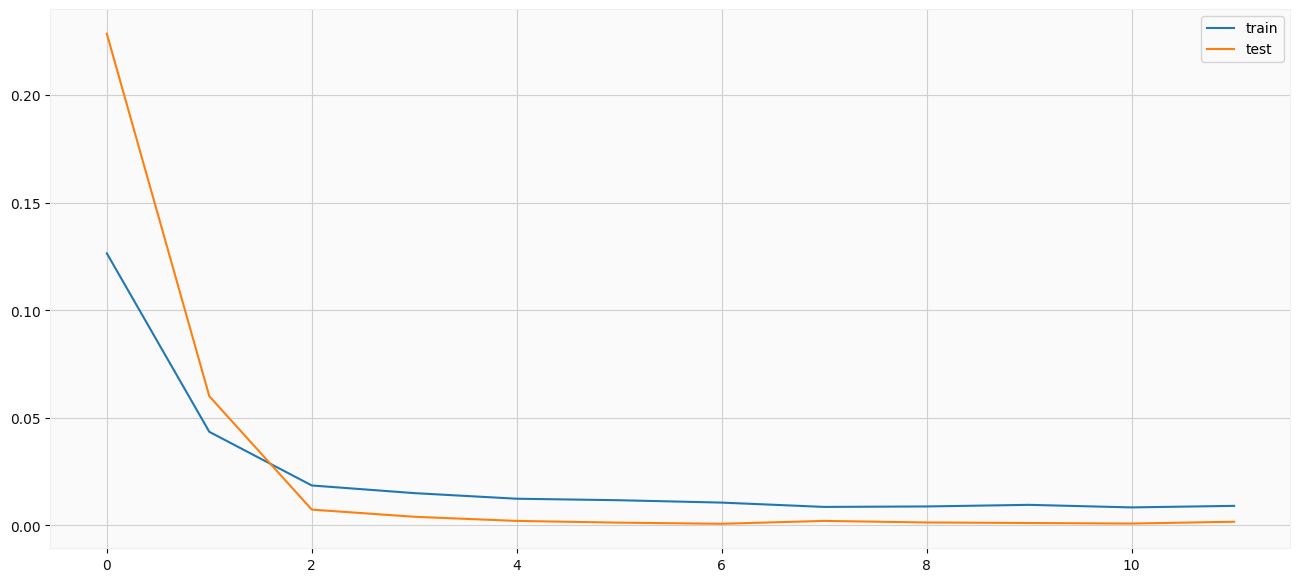

In [22]:
plt.figure(figsize=(16,7))
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [23]:
# Τα μετατρέπουμε στην κανονική τους μορφή και κάνουμε τις προβλέψεις
predicted_btc_price_test_data = model_from_saved_checkpoint.predict(testX)
predicted_btc_price_test_data = scaler_test.inverse_transform(predicted_btc_price_test_data.reshape(testX.shape[0], 1))
test_actual = scaler_test.inverse_transform(testY.reshape(testX.shape[0], 1))

def rmse(predictions, targets):
    return np.sqrt(np.mean((predictions-targets)**2))

print(f"Mean Absolute Error: {mean_absolute_error(predicted_btc_price_test_data, test_actual)}")
print(f"Mean Square Error: {mean_squared_error(predicted_btc_price_test_data, test_actual)}")
print(f"r2 score: {r2_score(predicted_btc_price_test_data, test_actual)}")
print(f"Root Mean Square Error: {rmse(predicted_btc_price_test_data, test_actual)}")

Mean Absolute Error: 40.07630509868407
Mean Square Error: 2358.8740712133704
r2 score: 0.7434322318666442
Root Mean Square Error: 48.568241384812055


In [24]:
# Τα μετατρέπουμε στην κανονική τους μορφή και κάνουμε τις προβλέψεις
predicted_btc_price_train_data = model_from_saved_checkpoint.predict(trainX)
predicted_btc_price_train_data = scaler_train.inverse_transform(predicted_btc_price_train_data.reshape(trainX.shape[0], 1))
train_actual = scaler_train.inverse_transform(trainY.reshape(trainY.shape[0], 1))

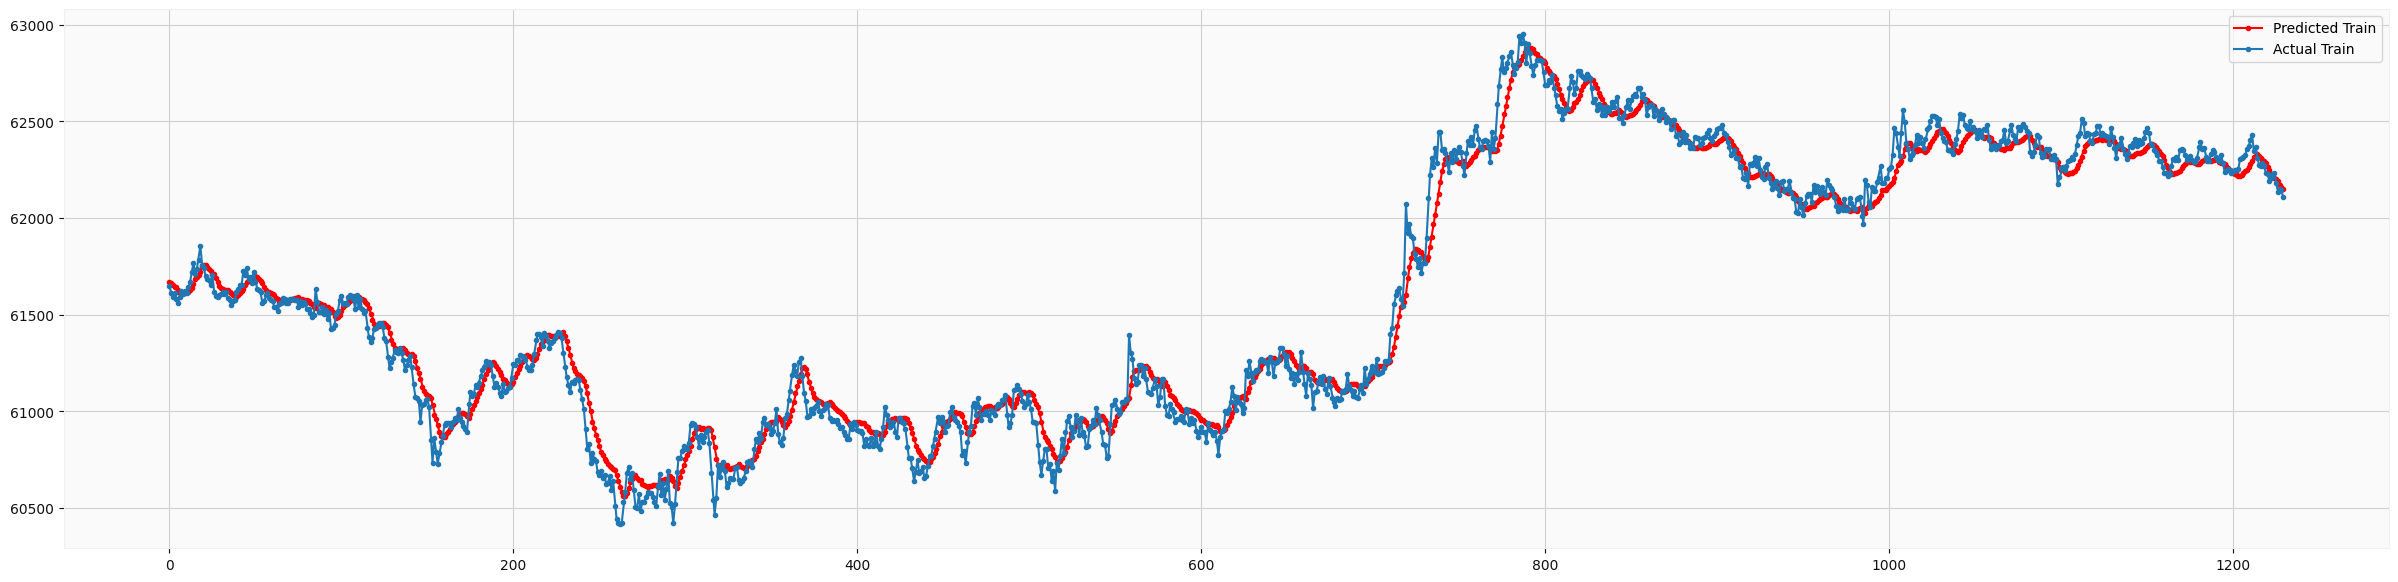

In [25]:
plt.figure(figsize=(30,7))
plt.plot(predicted_btc_price_train_data, 'r', marker='.', label='Predicted Train')
plt.plot(train_actual, marker='.', label='Actual Train')
plt.legend()
plt.show()

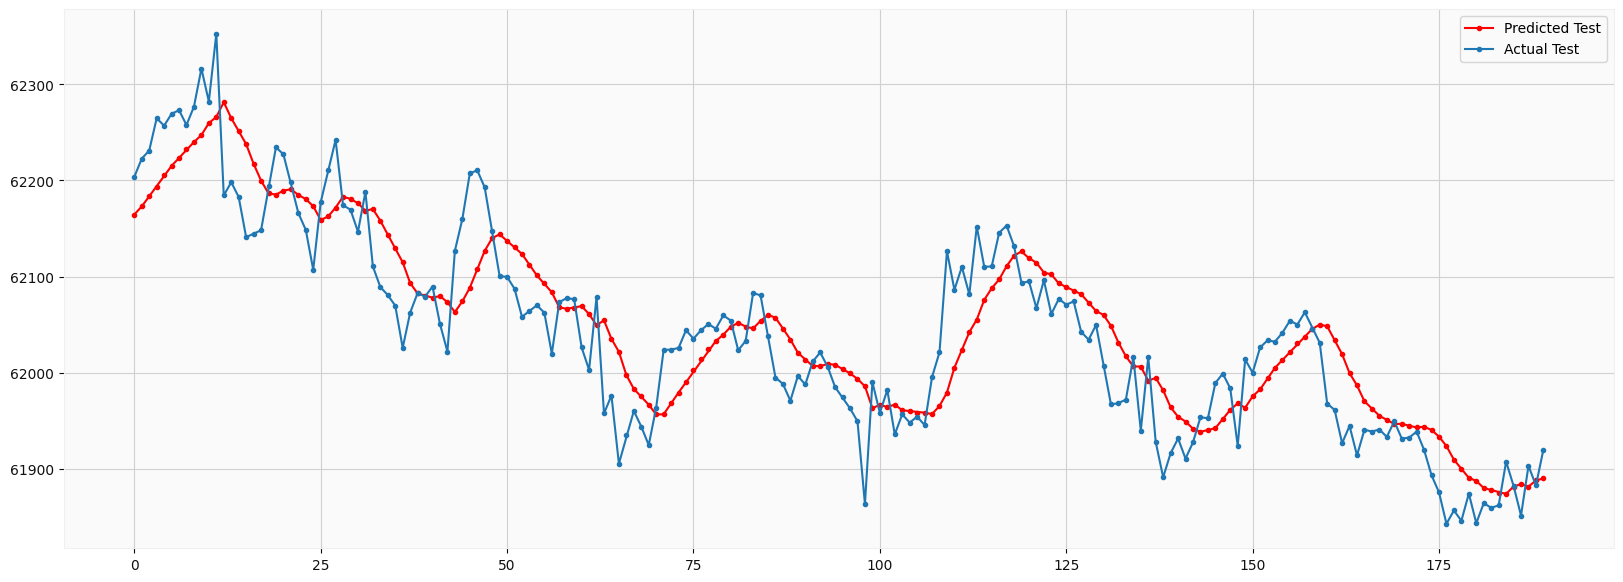

In [26]:
plt.figure(figsize=(20,7))
plt.plot(predicted_btc_price_test_data, 'r', marker='.', label='Predicted Test')
plt.plot(test_actual, marker='.', label='Actual Test')
plt.legend()
plt.show()

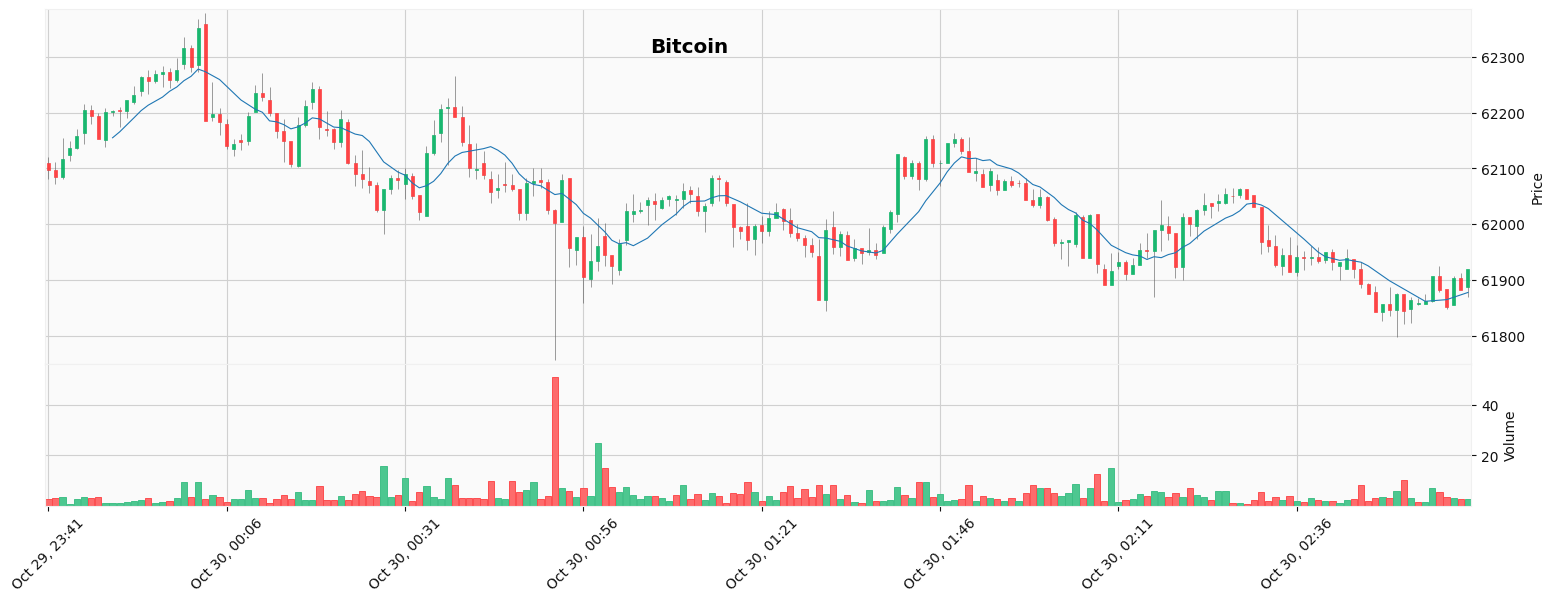

In [27]:
mpf.plot(btc_input_df[-200:],
         title="Bitcoin",
         type="candle", 
         volume=True, 
         mav=(10),
         tight_layout=True,
         figratio=(20,7),
         style='yahoo',)

In [28]:
testX.shape

(190, 10, 1)

In [29]:
# για να προβλέψουμε την τιμή της επ΄όμενης μέρας που δεν έχουμε στα δεδομένα μας, θα πρέπει να
# περάσουμε στο μον΄τέλο μας τις look_back μέρες και θα πάρουμε σαν output την επόμενη μέρα
# Όμοια για να πάρουμε την επόμενη μέρα από την αυριανή μέρα, θα δώσουμε σαν input στο μοντέλο μας
# τα δεδομένα των lookback - 1 μερών για να πάρουμε σαν output την μεθαυριανή μέρα
lookback_period = 15
testX_last_days = testX[testX.shape[0] - lookback_period:]
print(testX_last_days.shape)
predicted_days_forecast_price_test_x = []

for i in range(lookback_period):  
    predicted_forecast_price_test_x = model_from_saved_checkpoint.predict(testX_last_days[i:i+1])
    predicted_forecast_price_test_x = scaler_test.inverse_transform(predicted_forecast_price_test_x.reshape(-1, 1))
    predicted_days_forecast_price_test_x.append(predicted_forecast_price_test_x)

predicted_days_forecast_price_test_x = np.array(predicted_days_forecast_price_test_x)
predicted_days_forecast_price_test_x = predicted_days_forecast_price_test_x.flatten()

predicted_btc_price_test_data = predicted_btc_price_test_data.flatten()
predicted_btc_test_concatenated = np.concatenate((predicted_btc_price_test_data, predicted_days_forecast_price_test_x))


(15, 10, 1)


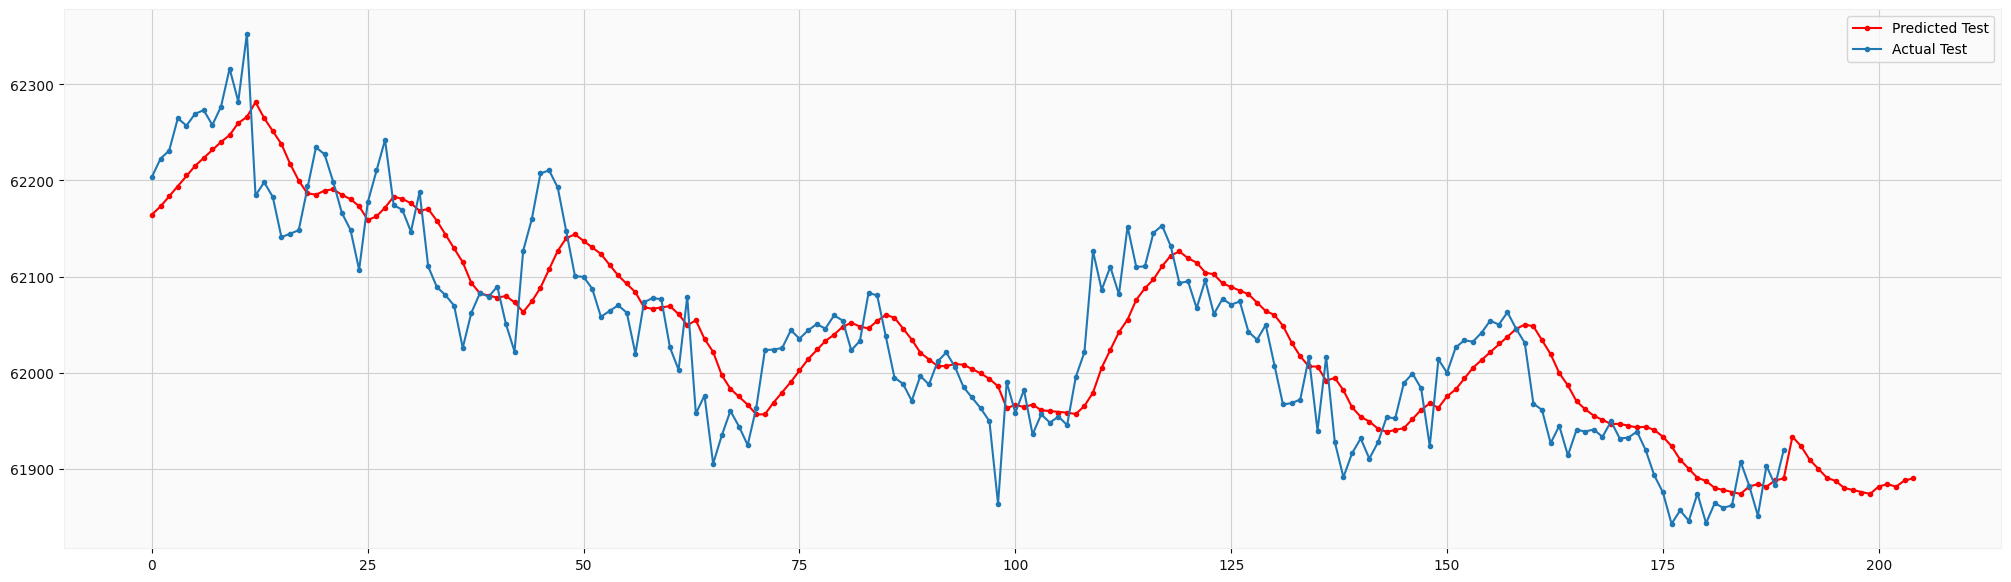

In [30]:
plt.figure(figsize=(25,7))
plt.plot(predicted_btc_test_concatenated, 'r', marker='.', label='Predicted Test')
plt.plot(test_actual, marker='.', label='Actual Test')
plt.legend()
plt.show()

In [31]:
df_strategy_actual = pd.DataFrame(test_actual)
df_strategy_predicted = pd.DataFrame(predicted_btc_price_test_data)

df_strategy_actual = df_strategy_actual.rename(columns={0: "close"})
df_strategy_predicted = df_strategy_predicted.rename(columns={0: "close"})

In [32]:
df_strategy_actual.head()

,close
0,62203.73
1,62222.69
2,62231.10
3,62264.69
4,62257.02


In [33]:
df_strategy_predicted.head()

,close
0,62164.585938
1,62172.980469
2,62183.675781
3,62193.218750
4,62205.761719


In [34]:
def classify(current, future):
    if future is None:
        return
    """
    Επιστρέφει 1 αν η τιμή στο μέλλον είναι αυξημένη ή
    0 αν η τιμή στο μέλλον είναι μειωμένη
    """
    if float(future) > float(current):
        return 1
    else:
        return 0

In [35]:
df_strategy_actual['future'] = df_strategy_actual["close"].shift(-1)
df_strategy_predicted['future'] = df_strategy_predicted["close"].shift(-1)
df_strategy_actual['target'] = list(map(classify, df_strategy_actual["close"], df_strategy_actual["future"]))
df_strategy_predicted['target'] = list(map(classify, df_strategy_predicted["close"], df_strategy_predicted["future"]))

frames = [df_strategy_actual, df_strategy_predicted]
result = pd.concat(frames, axis=1, ignore_index=True)
result = result.rename(columns={0: "actual_close", 
                                1:"actual_future_close", 
                                2:"actual_target",
                                3:"predicted_close",
                                4:"predicted_future_close",
                                5:"predicted_target"})

result.head(20)

,actual_close,actual_future_close,actual_target,predicted_close,predicted_future_close,predicted_target
0,62203.73,62222.69,1,62164.585938,62172.980469,1
1,62222.69,62231.10,1,62172.980469,62183.675781,1
2,62231.10,62264.69,1,62183.675781,62193.218750,1
3,62264.69,62257.02,0,62193.218750,62205.761719,1
4,62257.02,62269.35,1,62205.761719,62215.171875,1
5,62269.35,62273.15,1,62215.171875,62223.742188,1
6,62273.15,62257.69,0,62223.742188,62232.609375,1
7,62257.69,62276.72,1,62232.609375,62239.976562,1
8,62276.72,62316.40,1,62239.976562,62247.242188,1
9,62316.40,62282.10,0,62247.242188,62259.710938,1


In [50]:
def trade(df, usd=100):
    cnt = 0
    btc = 0
    percentage_buy = 0.5
    percentage_sell = 0.2
    profit = 0
    
    for index, target in enumerate(result['predicted_target']):
        # αν μας τελείωσαν όλα, τελειώνει ο αλγόριθμος
        if usd == 0 and btc == 0:
            return 0
        
        # αγοράζουμε
        if target == 1 and usd > 10:
            buy = percentage_buy * usd
            btc = buy / df['actual_close'][index] + btc
            usd = usd - buy
            # print(f'{cnt} --------------------------------------------------------------------')
            # print(f"You have spent {buy} dollars Total: {btc} btc")
            # print('-------------------------------------------------------------')
            cnt += 1

        # πουλάμε 
        if target == 0 and btc > 0:
            sell = btc * percentage_sell 
            usd = sell * df['actual_close'][index] + usd
            btc = btc - sell
            # print(f'{cnt} --------------------------------------------------------------------')           
            # print(f"Real: You get: {sell} usd Total: {usd} usd")
            # print("--------------------------------------------")
            cnt += 1
    
    # print("-------------- END ----------------")
    print(f"USD: {usd}, BTC:{format(float(btc), 'f')} -> {btc * df.iloc[-1,0]} usd\n\nTotal: {usd + df.iloc[-1,0] * btc} usd")  
    return usd, btc

In [37]:
usd, btc = trade(result)

USD: 75.87292462229794, BTC:0.000382 -> 23.654742431504513 usd

Total: 99.52766705380246 usd


In [38]:
def sharpe_ratio(rets):
    return rets.mean() / rets.std()

def positions(x, theta):
    M = len(theta) - 2
    T = len(x)
    Ft = np.zeros(T)
    for t in range(M, T):
        xt = np.concatenate([[1], x[t - M:t], [Ft[t - 1]]])
        Ft[t] = np.tanh(np.dot(theta, xt))
    return Ft

def returns(Ft, x, delta=0):
    T = len(x)
    rets = Ft[0:T - 1] * x[1:T] - delta * np.abs(Ft[1:T] - Ft[0:T - 1])
    return np.concatenate([[0], rets])

def gradient(x, theta, delta):
    Ft = positions(x, theta)
    R = returns(Ft, x, delta)
    T = len(x)
    M = len(theta) - 2
    
    A = np.mean(R)
    B = np.mean(np.square(R))
    S = A / np.sqrt(B - A ** 2)

    dSdA = S * (1 + S ** 2) / A
    dSdB = -S ** 3 / 2 / A ** 2
    dAdR = 1. / T
    dBdR = 2. / T * R
    
    grad = np.zeros(M + 2)  
    dFpdtheta = np.zeros(M + 2)  
    
    for t in range(M, T):
        xt = np.concatenate([[1], x[t - M:t], [Ft[t-1]]])
        dRdF = -delta * np.sign(Ft[t] - Ft[t-1])
        dRdFp = x[t] + delta * np.sign(Ft[t] - Ft[t-1])
        dFdtheta = (1 - Ft[t] ** 2) * (xt + theta[-1] * dFpdtheta)
        dSdtheta = (dSdA * dAdR + dSdB * dBdR[t]) * (dRdF * dFdtheta + dRdFp * dFpdtheta)
        grad = grad + dSdtheta
        dFpdtheta = dFdtheta

        
    return grad, S

def train(x, epochs=2000, M=8, commission=0, learning_rate = 0.3):
    theta = np.random.rand(M + 2)
    sharpes = np.zeros(epochs) 
    for i in range(epochs):
        grad, sharpe = gradient(x, theta, commission)
        theta = theta + grad * learning_rate

        sharpes[i] = sharpe
    
    
    print("finished training")
    return theta, sharpes

In [39]:
rets = btc_input_df['close'].copy().diff()[1:1000]

x = np.array(rets)

N = 900 
P = 100
x_train = x[:N]
x_test = x[-P:]

std = np.std(x_train)
mean = np.mean(x_train)

x_train = (x_train - mean) / std
x_test = (x_test - mean) / std

In [40]:
rets.head()

time
2021-10-29 03:02:00   -58.84
2021-10-29 03:03:00    -9.92
2021-10-29 03:04:00     7.99
2021-10-29 03:05:00    88.66
2021-10-29 03:06:00    62.83
Name: close, dtype: float64

In [41]:
%%time
np.random.seed(0)
print('start training')
theta, sharpes = train(x_train, epochs=300, M=10, commission=0, learning_rate=0.3)

start training
finished training
CPU times: total: 15.2 s
Wall time: 15.7 s


Sharpe ratio: 0.10351696398369056


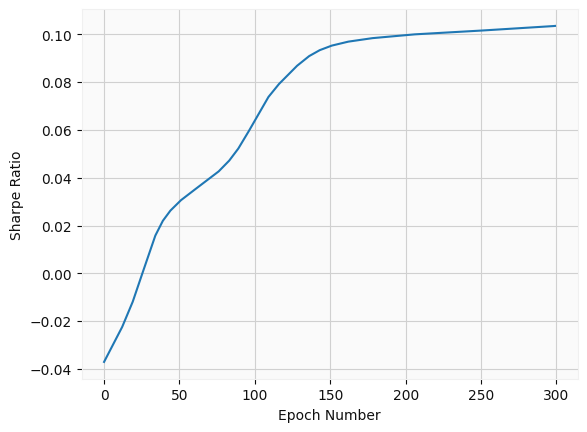

In [42]:
plt.plot(sharpes)
plt.xlabel('Epoch Number')
plt.ylabel('Sharpe Ratio')
print(f"Sharpe ratio: {sharpes[-1]}")

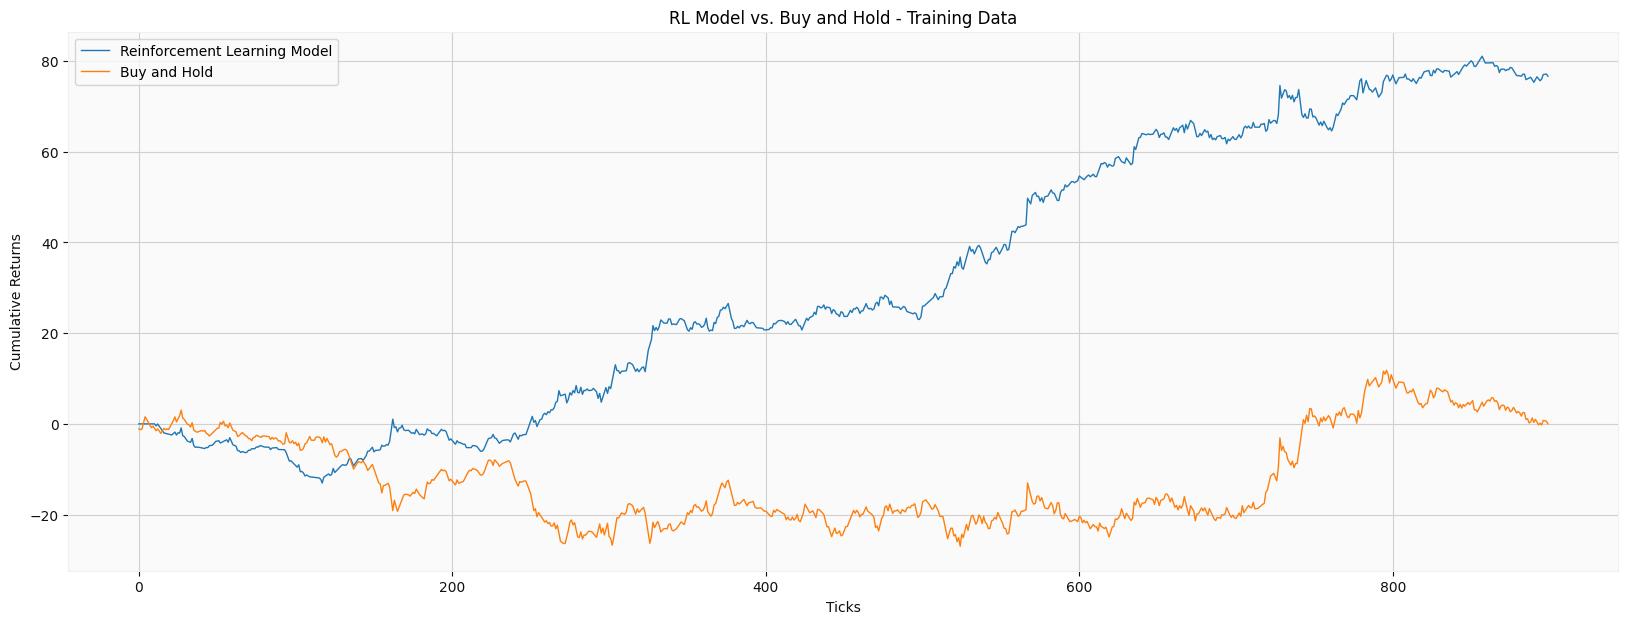

In [43]:
train_returns = returns(positions(x_train, theta), x_train)
test_returns = returns(positions(x_test, theta), x_test)
plt.figure(figsize=(20,7))
plt.plot(train_returns.cumsum(), label="Reinforcement Learning Model", linewidth=1)
plt.plot(x_train.cumsum(), label="Buy and Hold", linewidth=1)
plt.xlabel('Ticks')
plt.ylabel('Cumulative Returns');
plt.legend()
plt.title("RL Model vs. Buy and Hold - Training Data");

Text(0.5, 1.0, 'RL Model vs. Buy and Hold - Test Data')

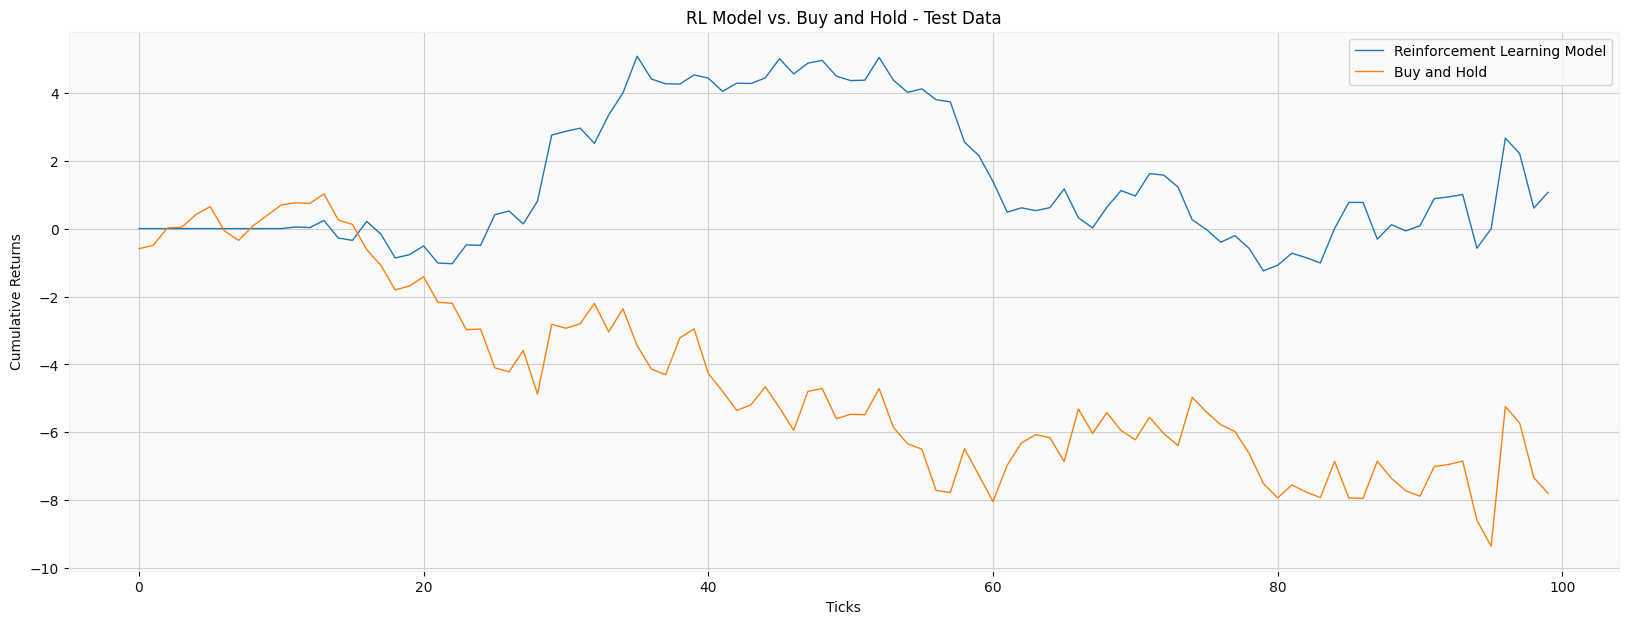

In [44]:
plt.figure(figsize=(20,7))
plt.plot(test_returns.cumsum(), label="Reinforcement Learning Model", linewidth=1)
plt.plot(x_test.cumsum(), label="Buy and Hold", linewidth=1)
plt.xlabel('Ticks')
plt.ylabel('Cumulative Returns')
plt.legend()
plt.title("RL Model vs. Buy and Hold - Test Data")

In [45]:
test_positions = positions(x_test, theta)

In [46]:
test_positions

array([ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.76216963,  0.95463318,  0.7440567 ,  0.67292861,  0.52872268,
       -0.75321488,  0.80573651,  0.97182417,  0.81863856,  0.95300978,
        0.67041578,  0.71388775, -0.71408093, -0.69539826, -0.78857938,
       -0.92496332, -0.60745216, -0.52486499,  0.94756423, -0.94235276,
        0.69720073, -0.74783575, -0.99646562,  0.95505023, -0.99771325,
        0.97944896,  0.82746398, -0.00844605,  0.99998128,  0.070595  ,
        0.75154704, -0.42607599, -0.05701066,  0.31088514, -0.92285342,
        0.67276799,  0.27716526,  0.94398675,  0.51927228, -0.99618993,
       -0.88473862,  0.86978909,  0.58730476,  0.73814047, -0.67012336,
        0.26411856,  0.9972064 , -0.92088196,  0.51146316,  0.97347896,
       -0.84643863,  0.19461246, -0.34133323, -0.96583971, -0.78728493,
       -0.54748084,  0.41849009,  0.99651841, -0.93578962,  0.59

In [47]:
test_positions.size

100

In [48]:
def trading_rrl(df, usd=100):
    cnt = 0
    btc = 0
    # percentage_buy = 0.2
    # percentage_sell = 0.2
    profit = 0
    
    for index, target in enumerate(test_positions):
        # αν μας τελείωσαν όλα, τελειώνει ο αλγόριθμος
        if usd == 0 and btc == 0:
            return (0,0)
        
        if target == 0:
            # print(f'{cnt} --------------------------------------------------------------------')
            # print(f"Nothing")
            # print('-------------------------------------------------------------')
            cnt += 1
            
        # αγοράζουμε
        if target > 0 and usd > 10:
            buy = target * usd
            # print(buy)
            btc = buy / df['actual_close'][index] + btc
            # print(df['actual_close'][index])
            usd = usd - buy
            # print(f'{cnt} --------------------------------------------------------------------')
            # print(f"You have spent {buy} usd Total: {format(float(btc), 'f')} btc")
            # print('-------------------------------------------------------------')
            cnt += 1


        # πουλάμε 
        if target < 0 and btc > 0:
            sell = btc * (target * -1) 
            usd = (sell * df['actual_close'][index]) + usd
            btc = btc - sell
            # print(f'{cnt} --------------------------------------------------------------------')           
            # print(f"You get: {sell} usd Total: {usd} usd")
            # print("--------------------------------------------")
            cnt += 1
    
    # print("-------------- END ----------------")
    print(btc)
    print(f"USD: {usd}, BTC:{format(float(btc), 'f')} -> {btc * df.iloc[-1,0]}\n\nTotal: {usd + df['actual_close'].values[-1] * btc} usd")
    return usd, btc

In [49]:
usd, btc = trading_rrl(result.copy())

4.575750331918385e-06
USD: 99.33294057418844, BTC:0.000005 -> 0.2833303690373798

Total: 99.61627094322583 usd
